# SLT-CE-2: Sampling

grade = 6

In this coding exercise we will test various Markov Chain Monte Carlo (MCMC) sampling procedures [1] introduced during the tutorial session. We will first tackle the image reconstruction problem followed by the traveling salesman problem.

## Task (image reconstruction problem)


Given a noisy [binary image](https://en.wikipedia.org/wiki/Binary_image) one needs to recover the original through denoising. To do so we will use the prototypical [Ising model](https://en.wikipedia.org/wiki/Ising_model) from physics as explained in section 8.3.3 of [2]. An undirected graphical model is designed to model (i) the adherence of the reconstruction to the observed noisy image and (ii) the correlation between neighboring pixels. We are interested in recovering a single image, the most likely one, with respect to the underlying distribution i.e. we do MAP inference to discover the peak of the posterior distribution $p(image\_reconstruction | noisy\_observation)$.


### References 
[0] [SLT Tutorial 3 on Sampling](https://ml2.inf.ethz.ch/courses/slt/tutorials/tutorial03-sampling.pdf)

[1] http://www.cs.princeton.edu/courses/archive/spr06/cos598C/papers/AndrieuFreitasDoucetJordan2003.pdf

[2] Bishop, Christopher M. "Pattern Recognition and Machine Learning." (2006).

## Model

Given a noisy, binary image $y=(y_1,\dots,y_n)$ where $y_i\in\{\pm1\}$ is the value of the i-th pixel, the Ising model tries to find a denoised image $x=(x_1,\dots,x_n)$ by minimizing the following energy function:

$$E(x|y) = - \frac{\beta}{2} \sum_{i} \frac{x_i}{\lvert N_i\rvert}\sum_{j \in N_i} x_j - \mu \sum_{i} x_i y_i$$

where $N_i$ is the set of neighbors of pixel $i$. For a 2D image the pixel neighbourhood $N_i$ usually involves $\lvert N_i\rvert=$ 4 or 8 surrounding pixels. In this exercise we consider only the 4 pixel neigbourhood (up, down, left and right pixels). The undirected probabilistic graphical model from where the energy function $E(x|y)$ is derived is explained in more detail in [2].

 <h2> Setup </h2>

We start by importing necessary python packages.

In [2]:
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import time
import gc

from skimage.transform import resize
from scipy.signal import fftconvolve
from scipy.signal import convolve2d
from scipy.stats import bernoulli
from sklearn.metrics import hamming_loss

from scipy.optimize import minimize_scalar
from multiprocessing import cpu_count
from pathos.multiprocessing import ProcessingPool as Pool




In [3]:
def flower(size=None, p=0.3):
    """Load image data for denoising
    
    Args:
        size (tuple): image size, default (300,300)
        p (float): noise fraction in [0,1]
        
    Returns:
        noisy: noisy image
        img: ground truth image
    """
    img = mpimg.imread("flower.png") # Load image
    
    # Binarize image
    img[img > 0.5] = 1
    img[img <= 0.5] = -1
    
    # Resize image 
    if size is not None:
        img = resize(img, size)
        img[img > 0] = 1
        img[img <= 0] = -1
    
    np.random.seed(13)

    flip = np.random.choice([-1, 1], size=img.shape, p=[p, 1-p])

    noisy = flip * img
    
    #print('flower_size',img.shape)
    return noisy, img

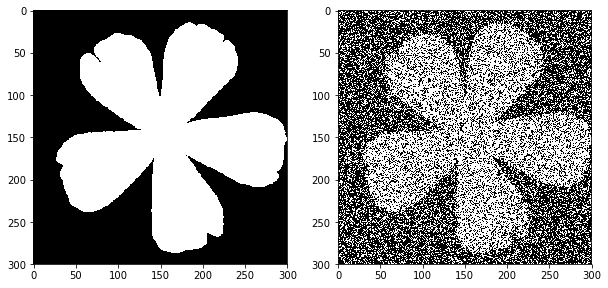

In [4]:
noisy, img = flower()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(img, cmap='gray')
plt.subplot(122)
plt.imshow(noisy,cmap='gray')
plt.show()

<h2 style="background-color:#f0b375;">
Section 4.0 
<span style=font-size:50%> Complete all problems in this section to get a pass on this exercise. </span>
</h2>

<p style="background-color:#adebad;">
Shortly describe the following sampling procedures, and provide the key formulas. See <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">markdown cheatsheet</a> for text editing.</p>

- **Metropolis**: Metropolis Sampling is a sampling procedure to emrpically describe an intractable distribution (such as the Gibbs distribution whose source of intractability is the denominator in our case) via its samples. In other words, it allows us to obtain samples from a distribution with almost sure probability for a large number of sampling iterations when certain conditions are met. It relies on MCMC sampling algorithm as its backbone and is presented below:

**MCMC Sampling Algorithm:**

* Define a family of transition distributions $ \{ \pi(.|c) \}_{c\in\mathcal{C}}$ 
* Pick arbitrary $c_0\in\mathcal{C}$ 
* Randomly sample $c_1 \leftarrow \pi(.|c_0)$
* Randomly sample $c_2 \leftarrow \pi(.|c_1)$
.
.
.
* Randomly sample $c_t \leftarrow \pi(.|c_{t-1})$

This induces a graph $G_\pi$ with an underlying **Markov Chain** defined on the solution space $\mathcal{C}$ since ve traverse the solution space with sufficiently large number of iterations. We are furthermore guaranteed convergence to a sample from the target distribution $p(c)$ as $t \rightarrow \infty$ if the following requirements on $G_\pi$ and $\pi(.|c)$ are met:

**$[M1]$:** $G_\pi$ is connected. **(Irreducibility of the MC)** <br>
**$[M2]$:** $\pi(c|c^\prime)p(c^\prime)=\pi(c^\prime|c)p(c)$ **(Detailed Balance)** <br>
**$[M3]$:** $\pi(c|c)>0 \forall{c\in\mathcal{C}}$ **(Aperiodicity of the MC)** <br>

Therefore, we guarantee that a stationary distribution for the MC exists and furthermore converges to our target distribution of $p(c)$ such that $\lim_{t \to +\infty} P(c_t = c) = P(c)$ <br>

**Metropolis Sampling**, is a special case of the Metropolis-Hasting Algorithm which is described below. In metropolis sampling, the proposed distribution is adjusted so that **$q(\tilde{c}|c_{t-1})=q(c_{t-1}|\tilde{c})$** in which case the accptance probability defined below depends only on the target distribution and more explicitly on the tempurature parameter $T$ and the predefined cost $R(c,X)$




- **Metropolis-Hastings**: Metropolis-Hastings is an algorithm complementary to the MCMC Sampling which allows the family of transition distributions $ \{ \pi(.|c) \}_{c\in\mathcal{C}}$ to indeed obey detailed-balance. For this purpose, Metropolis_hastings incorporates a proposal distribution and sample acceptance step to the sampling procedure which can be sumarized fully as given below:

**Metropolis-Hastings Algorithm:**

* Define a family of proposal distributions $ \{ q(.|c) \}_{c\in\mathcal{C}}$  such that $G_q$ is connected and $q(c|c)>0 \forall{c\in\mathcal{C}}$ <br>

* Pick arbitrary $c_0\in\mathcal{C}$ 

* Randomly sample $\tilde{c} \leftarrow q(.|c_{t-1})$

* Randomly sample $b \leftarrow Ber(A(c_{t-1},\tilde{c}))$ where $A(c_{t-1},\tilde{c}):=min\{1,\frac{q(c_{t-1}|\tilde{c})p(\tilde{c})}{q(\tilde{c}|c_{t-1})p(c_{t-1})}\}$ is the acceptance probability of the sample generated from the proposed distribution at step $t$

* if $b=1$ then $c_t\leftarrow \tilde{c}$ <br>
  else $c_t\leftarrow c_{t-1}$ <br>
  
Naturally, the transitional probability is then defined as the overall probability $\pi(c_t|c_{t-1}) = P(output \ c_t|input \ c_{t-1})$. Then, Metropolis-Hastings algorithm assures us that $ \{ \pi(.|c) \}_{c\in\mathcal{C}}$ satisfies **$[M1]$**,**$[M2]$**,**$[M3]$** as desired.



- **Simulated Annealing**: In Metropolis-Hastings algorithm, (in particular, Metropolis sampling in our case), the traversal probability of the underlying Markov Chain depends on the tempurature parameter $T$ via the equality $\pi(\tilde{c}|c_{t-1})=A(c_{t-1},\tilde{c})q(\tilde{c}|c_{t-1})$. Therefore, $T$ plays a crucial role as a hyperparamters that directly effects the step size of iterations of the sampling procedure. In particular, a large $T$ favors roaming the solution space freely while bearing in mind the cost constraint less since in this case the algorithm easily accpets new candidates. This is simply due to the fact that $A(c_{t-1},\tilde{c})$ approaches 1 with $T$ being large. This behaviour therefore may lead the sampling process to farther solution candidates in each iteration irrespective of the initializtion, which is crucial for exploring the solution space sufficiently. On the other hand, a too large choice for this parameter may result in overshoots and delay the convergence of our algorithm, in which case, a smaller $T$ is required to delicately attain the mininima, favoring new candidates that indeed have lower costs. Therefore, simulated annealing performs a decay of the tempurature parameter throughout the iterations(in each epoch for our case) and hence, first gets the chance to explore all minimas and escape possible local minimas that we don't desire and then at the later iterations descend further into the (hopefully) correct minima without oscillations. The sumarized algorithm is presented below:

* Set $T$ large <br>


* Pick arbitrary $c_0\in\mathcal{C}$ 

* while $T<\epsilon$: (where $\epsilon$ is an emprical hyperparameter)
     
* for $t=0,1,...,N$:<br>
     {<br>
     {

* Randomly sample $\tilde{c} \leftarrow q(.|c_{t-1})$

* Randomly sample $b \leftarrow Ber(A(c_{t-1},\tilde{c}))$ where $A(c_{t-1},\tilde{c}):=min\{1,\frac{q(c_{t-1}|\tilde{c})p(\tilde{c})}{q(\tilde{c}|c_{t-1})p(c_{t-1})}\}$ is the acceptance probability of the sample generated from the proposed distribution at step $t$

* if $b=1$ then $c_t\leftarrow \tilde{c}$ <br>
  else $c_t\leftarrow c_{t-1}$ <br>
  
  }
  
* Randomly sample ${c_0} \leftarrow q(.|c_N)$

* Reduce $T$

}

<p style="background-color:#adebad;">
    Implement the energy function introduced in the model section of the notebook.<br>
    <b> (!)</b> Deliberately implement a naive solution, which explicitly performs (nested) loops to compute the sums. 
    </p>

In [5]:
def energy(img_noisy_observation, img_estimate, beta=2.5, mu=1):
    """Compute the energy for given estimate 'img_estimate' which
    is our vector x in the original model, with respect to the 
    observation 'img_noisy_observation', which corresponds to the vector y in the model.

    Args:
        img_estimate (np.ndarray): estimated image matrix
        img_noisy_observation (np.ndarray): noisy image matrix

    Returns:
        energy (float): energy of the estimate given observation
    """
    height = img_estimate.shape[0]
    width = img_estimate.shape[1]
    
    E = 0
    #counter = 0
    for i in range(height):
        for j in range(width):
            if (i==0):
                if(j==0):
                    E = E - (0.25)*(beta/2.0)*(img_estimate[i+1,j] + img_estimate[i,j+1])*(img_estimate[i,j])
                elif(j==(width-1)):
                    E = E - (0.25)*(beta/2.0)*(img_estimate[i+1,j] + img_estimate[i,j-1])*(img_estimate[i,j])
                else:
                    E = E - (0.25)*(beta/2.0)*(img_estimate[i+1,j] + img_estimate[i,j-1] + img_estimate[i,j+1])*(img_estimate[i,j])
            elif(i==(height-1)):
                if(j==0):
                    E = E - (0.25)*(beta/2.0)*(img_estimate[i-1,j] + img_estimate[i,j+1])*(img_estimate[i,j])
                elif(j==(width-1)):
                    E = E - (0.25)*(beta/2.0)*(img_estimate[i-1,j] + img_estimate[i,j-1])*(img_estimate[i,j])
                else:
                    E = E - (0.25)*(beta/2.0)*(img_estimate[i-1,j] + img_estimate[i,j-1] + img_estimate[i,j+1])*(img_estimate[i,j]) 
            elif ((j==0) and (i!=0) and (i!=(height-1))):
                E = E - (0.25)*(beta/2.0)*(img_estimate[i+1,j] + img_estimate[i-1,j] + img_estimate[i,j+1])*(img_estimate[i,j])
            elif(j==(width-1) and (i!=0) and (i!=(height-1))):
                E = E - (0.25)*(beta/2.0)*(img_estimate[i-1,j] + img_estimate[i+1,j] + img_estimate[i,j-1])*(img_estimate[i,j])
            else:
                E = E - (0.25)*(beta/2.0)*(img_estimate[i-1,j] + img_estimate[i+1,j] + img_estimate[i,j-1] + img_estimate[i,j+1])*(img_estimate[i,j])
            
            E = E - mu*img_estimate[i,j]*img_noisy_observation[i,j]
    
            #counter = counter + 1
    #print(counter)
    #print(E)
        
    
    return E 

<p style="background-color:#adebad;">Make sure to get the correct result:</p>

In [6]:
assert np.isclose(energy(*flower()), -145700.75)
print(energy(*flower()))

-145700.75


<p style="background-color:#adebad;">Implement metropolis sampling.<br>
<b>(!)</b> Deliberately implement a naive solution, which loops over each pixel, attempts a flip, measures the energy before and after, and then decides whether to accept the flip, or not. Use the naive energy function from before.
</p>

In [7]:
def metropolis(img_noisy_observation, epochs, T=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using energy.

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of the simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    #Since metropolis, undirected graph induced Gq
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()#c_t-1
    
    energies = [] #list of energies of estimated image wrt noisy observation throughout each epoch
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, idx in enumerate(np.random.permutation(n_pixels)):#Naively goes through permuted pixels(i.e randomly)
            
                
            estimate_temp = estimate.copy()#c_tilde
            #proposed solution sample, each image is a soln with Ndata=npixels:
            flipped_pixel =  (-1)*estimate_temp[idx//width,idx%width].copy()
            estimate_temp[idx//width,idx%width] = flipped_pixel
            #estimate_temp[idx//width,idx%width] = flipped_pixel #Flip the pixel corresponding to idx
            #print(idx)
            #print(idx//width)
            #print(idx%width)
            #For a randomized acceptance probability:
            p_accept = min(1, np.exp((-1.0/T)*(energy(noisy_img,estimate_temp)-energy(noisy_img,estimate))))
            #p_accept = min(1, np.exp((-1.0/T)*(local_energy_change(noisy_img,estimate_temp,idx//width,idx%width,beta=2.5,mu=1)-local_energy_change(noisy_img,estimate,idx//width,idx%width,beta=2.5,mu=1))))
            #b = np.random.binomial(size=1, n=1, p=p_accept)
            #b = np.random.choice([0,1], 1, p=[1-p_accept,p_accept])
            #b = bernoulli.rvs(p_accept,size=1)
            if(np.random.uniform(size=1) <= p_accept):
                estimate = estimate_temp.copy()
                #assign c_t
            else:
                estimate = estimate
            
            print("Finished {:6.2f}% of epoch {}".format(cnt/n_pixels * 100, e+1), end="\r")
            
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Evaluate your implemented metropolis algorithm, using the provided evaluation function.<br>
    The energy should decrease over epochs. The reconstructed image should be a denoised version of the noisy image.
    </p>

In [6]:
def evaluate_ising(method, img_noisy_observation, img_original, epochs=1, T=1, surpress=False):
    """ Given a sampling method, we will run the sampling procedure 
    for the specifed number of epochs. We measure time and reconstruction
    efficiency.

    Args:
        method (function pointer): sampling method
        img_noisy_observation (np.ndarray): noisy image matrix
        img_original (np.ndarray): original image matrix
        epochs (int): number of epochs to run the sampling, one epoch means going through all pixels once.
        T (float): The positive temperature of the simulation
    """
    print('Evaluate_ising_size:',img_noisy_observation.shape)
    start_time = time.time()
    img_estimate, energies = method(img_noisy_observation, epochs, T)
    execution_time = time.time() - start_time

    if not surpress:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))

        ax1.plot(energies, marker="x")
        ax1.set_xlabel('epoch')
        ax1.set_ylabel('energy')

        ax2.imshow(img_estimate, cmap='gray')
        ax2.set_title('Reconstruction')
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)

        ax3.imshow(img_noisy_observation, cmap='gray')
        ax3.set_title('Input')
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        plt.suptitle("{} updates per second".format(int(img_original.size*epochs/execution_time)))

        plt.show()
    
    return energies[-1], hamming_loss(y_pred=img_estimate.flatten(), y_true=img_original.flatten())

<p style="background-color:#adebad;">
    The naive implementation is incredibly slow, so we use a downsampled image for evaluation.
</p>

Evaluate_ising_size: (32, 32)


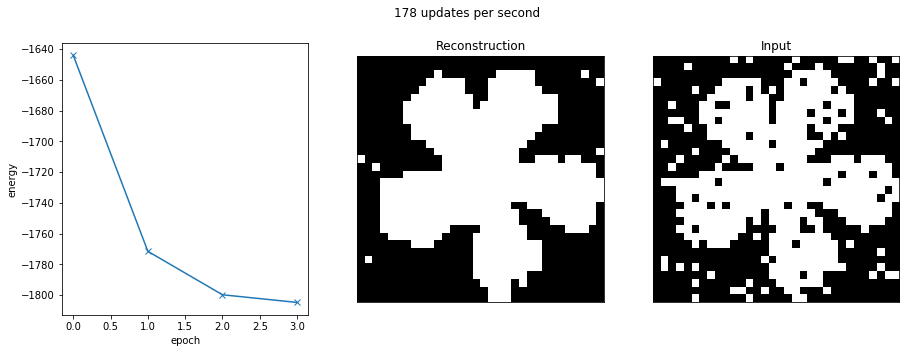

In [9]:
E_metro = evaluate_ising(metropolis, *flower(size=(32,32), p=0.1), epochs=3)

<h2 style="background-color:#f0b375;">
Section 4.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 4.5 </span>
</h2>

<p style="background-color:#adebad;">
We are now considering a different problem. We want to solve the <a href="https://en.wikipedia.org/wiki/Travelling_salesman_problem">traveling salesman problem</a> for N=532 major cities in the USA.
</p>

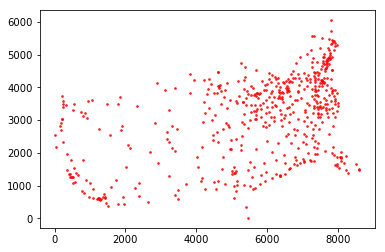

In [10]:
coordinates = pd.read_csv("cities.csv", names=['x', 'y'], sep=';', index_col=False)
coordinates = np.asarray(coordinates)  # Nx2 array containing the coordiantes of the cities
plt.scatter(coordinates[:,0], coordinates[:,1], s=3, c="r", alpha=0.75)
plt.show()

<p style="background-color:#adebad;">
Implement the distance function for the TSP:
</p>

In [11]:
def distance(coordinates, route=None):
    """Calculate travel distance.
    
    If no route is given, assumes that coordinates are travelled in order,
    starting at the first entry, and connecting the last entry again with the first.
    
    Args:
        coordinates (np.ndarray): route coordinates (assume in units of meters)
        route: permutation of coordinate order
        
    Returns:
        float: traveled distance in units of kilometers
    """
    dist=0
    if route is None:
        coordinates = coordinates
        #for i in range(531):
            #dist = dist + np.sqrt((coordinates[i+1,0]-coordinates[i,0])**2 + (coordinates[i+1,1]-coordinates[i,1])**2)
        #dist = dist + np.sqrt((coordinates[0,0]-coordinates[531,0])**2 + (coordinates[0,1]-coordinates[531,1])**2)
    if route is not None:
        coordinates = coordinates[route]#Switches the cities in accordance with the permutation
        #for i in range(531):
            #dist = dist + np.sqrt((coordinates[i+1,0]-coordinates[i,0])**2 + (coordinates[i+1,1]-coordinates[i,1])**2)
        #dist = dist + np.sqrt((coordinates[0,0]-coordinates[531,0])**2 + (coordinates[0,1]-coordinates[531,1])**2)   
    
    
    x_coords = coordinates[:,0]
    y_coords = coordinates[:,1]
    
    x_coords_shifted = np.roll(x_coords.copy(),1)
    y_coords_shifted = np.roll(y_coords.copy(),1)
    
    x_distances = np.square((x_coords - x_coords_shifted))
    y_distances = np.square((y_coords - y_coords_shifted))

    
    distances = np.sqrt(x_distances + y_distances)
    dist = np.sum(distances)
    dist = dist/1e3
    #print(dist)
    return dist

<p style="background-color:#adebad;">
Make sure it returns the correct value:
</p>

In [12]:
assert np.isclose(distance(coordinates), 978.3514183630234)

In [13]:
def evaluate_tsp(method, coordinates, epochs=1):
    """Evaluate sampling method on coordinates
    
    Args:
        method (function pointer): sampling method
        coordinates (np.ndarray): city coordinates, shape Nx2
        epochs (int): number of epochs to run the sampling
    """
    np.random.seed(7)
    N = coordinates.shape[0]
    route = np.random.permutation(N)
 
    start_time = time.time()
    route, distances = method(coordinates, route, epochs)
    execution_time = time.time() - start_time

    if not (np.sort(route) == range(N)).all():
        raise ValueError("Returned route is not valid!")

    x, y = coordinates[route, 0], coordinates[route, 1]
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(121)
    plt.plot(distances, marker="o", markersize=3)
    plt.plot([0, len(distances)], [27686/1000,27686/1000], c="green") # best known solution
    plt.grid(axis="y")
    
    plt.subplot(122, xticks=[], yticks=[])
    plt.plot(x, y, alpha=0.5, c="blue", marker="o", markerfacecolor="red", markersize=3, linewidth=1)
    plt.plot([x[0], x[-1]], [y[0], y[-1]], alpha=0.5, c="blue", linewidth=1)
    
    plt.show()

<p style="background-color:#adebad;">
First, solve the traveling salesman problem with metropolis, and then with simulated annealing. <br>
We consider all permutations of $(1,\dots,N)$ as the solution space, so one route corresponds to one permutation. <br>
As proposals use transpositions instead of pixel flips. <br>
More precisely, pick a random index $i$, and exchange it with its successor, i.e. $(x_1,\dots,x_i, x_{i+1},\dots,x_N) \rightarrow (x_1,\dots,x_{i+1}, x_{i},\dots,x_N)$.<br>
    Keep in mind, that TSP goes in a cycle, so the successor of N is 1.
</p>

In [16]:
def metropolis_tsp(coordinates, route=None, epochs=1, T=1.0):
    """Metropolis for TSP

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        epochs (int): number of loops through all cities.
        T (float): Temperature of simulation

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))
    for e in range(epochs):
        
        for idx in np.random.permutation(N):
            
                
            #proposed solution sample, each route is a soln with Ndata=N:
            #print(route[idx])
            #print(route[(idx+1%532)])
            route_temp = route.copy()#c_tilde
            value_temp = route_temp[idx].copy() #Flip the adjacent cities in the proposed routes
            route_temp[idx] = route[(idx+1)%532].copy()
            route_temp[(idx+1)%532] = value_temp.copy()
            #print(route_temp[idx])
            #print(route_temp[(idx+1%532)])
            #For a randomized acceptance probability:
            p_accept = np.array([1, np.exp((-1.0/T)*(distance(coordinates,route_temp)-distance(coordinates,route)))]).min()
            #p_accept = ((energy(noisy_img,estimate_temp)-energy(noisy_img,estimate)) < 0)#Deterministic
            #b = np.random.binomial(size=1, n=1, p=p_accept)
            if(np.random.uniform(size=1) <= p_accept):
                route = route_temp.copy()#assign c_t
            else:
                route = route
        
        distances.append(distance(coordinates, route))
        #print(e)
        #print(distances[-1])

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your metropolis algorithm for the traveling salesman problem.
</p>

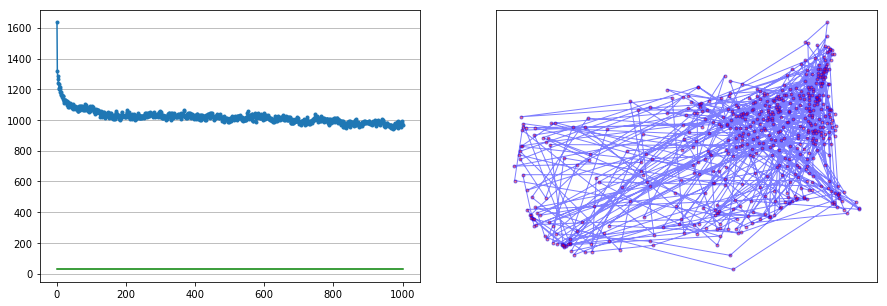

In [17]:
evaluate_tsp(metropolis_tsp, coordinates, epochs=1000)

In [18]:
def simulated_annealing(coordinates, route=None, epochs=1, T=20.0, eta=0.995):
    """Simulated Annealing for TSP

    T(n) = T * eta**n

    Args:
        coordinates (np.ndarray): initial route consisting of coordinates
        route (array): inital route
        epochs (int): number of loops through all cities.
        T (float): Initial temperature
        eta (float): Exponential cooling rate

    Returns:
        route (np.ndarray): optimized route
        distances (np.ndarray): travel distance after each epoch
    """
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        for idx in np.random.permutation(N):
            
            #proposed solution sample, each route is a soln with Ndata=N:
            #print(route[idx])
            #print(route[(idx+1%532)])
            route_temp = route.copy()#c_tilde
            value_temp = route_temp[idx].copy() #Flip the adjacent cities in the proposed routes
            route_temp[idx] = route[(idx+1)%532].copy()
            route_temp[(idx+1)%532] = value_temp.copy()
            #if ((distance(coordinates,route_temp)-distance(coordinates,route)) < 0):
                #route = route_temp
            #else:
                #print(route_temp[idx])
                #print(route_temp[(idx+1%532)])
                #For a randomized acceptance probability:
            p_accept = np.array([1, np.exp((-1.0/T)*(distance(coordinates,route_temp)-distance(coordinates,route)))]).min()
            b = np.random.binomial(size=1, n=1, p=p_accept)
            if(np.random.uniform() <= p_accept):
                route = route_temp#assign c_t
            else:
                route = route
        #if(e%10==0 and e!=0):
        T = T*(eta) #Simulated Annealing
            #print(T)
        
        #print(e)
        #print(distances[-1])
                
        distances.append(distance(coordinates, route))

    return np.asarray(route), np.asarray(distances)

<p style="background-color:#adebad;">
Evaluate your simulated annealing algorithm for the traveling salesman problem.
</p>

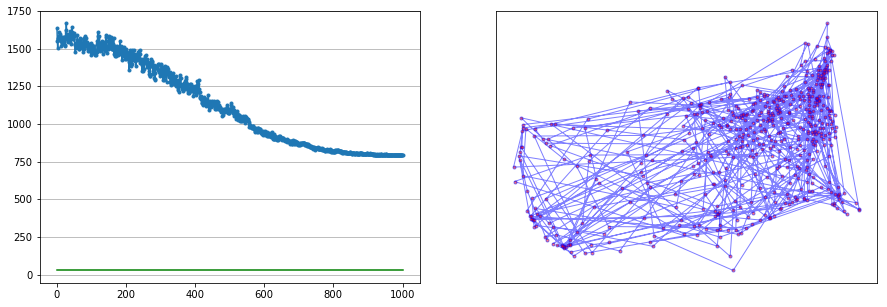

In [19]:
evaluate_tsp(simulated_annealing, coordinates, epochs=1000)

<h2 style="background-color:#f0b375;">
Section 5.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.0 </span>
</h2>

<p style="background-color:#adebad;">
    Optimize the calculation of the naive metropolis for the Ising problem by taking into account that the energy change caused by a single flip depends only on the affected pixel's value, and its neighborhood.<br>
    More precisely, implement the function local_energy_change, and use it in the method local_metropolis.
</p>

In [22]:
def local_energy_change(noisy, estimate, i, j, beta, mu):
    """
    
    Local energy difference between unflipped and flipped pixel i,j 
    
    Args:
        noisy: noisy reference image
        estimate: current denoising estimate
        i,j: Position of pixel
    
    Returns:
        float: local energy difference when pixel i,j is flipped 
    """
    height = estimate.shape[0]
    width = estimate.shape[1]
    dE=0
    
    if (i==0):
        if(j==0):
            dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i+1,j] + estimate[i,j+1])*(estimate[i,j])
        elif(j==(width-1)):
            dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i+1,j] + estimate[i,j-1])*(estimate[i,j])
        else:
            dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i+1,j] + estimate[i,j-1] + estimate[i,j+1])*(estimate[i,j])
    elif(i==(height-1)):
        if(j==0):
            dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i-1,j] + estimate[i,j+1])*(estimate[i,j])
        elif(j==(width-1)):
            dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i-1,j] + estimate[i,j-1])*(estimate[i,j])
        else:
            dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i-1,j] + estimate[i,j-1] + estimate[i,j+1])*(estimate[i,j]) 
    elif ((j==0) and (i!=0) and (i!=(height-1))):
        dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i+1,j] + estimate[i-1,j] + estimate[i,j+1])*(estimate[i,j])
    elif(j==(width-1) and (i!=0) and (i!=(height-1))):
        dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i-1,j] + estimate[i+1,j] + estimate[i,j-1])*(estimate[i,j])
    else:
        dE = dE - 2*(0.25)*(beta/2.0)*(estimate[i-1,j] + estimate[i+1,j] + estimate[i,j-1] + estimate[i,j+1])*(estimate[i,j])
            
    dE = dE - mu*estimate[i,j]*noisy[i,j]
            
    return dE

def local_metropolis(img_noisy_observation, epochs, T=1.0, beta=2.5, mu=1):
    """Metropolis sampling
    
    For each epoch, loop over every pixel and attempt flip using local_energy_change 

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels
        T (float): Temperature of simulation

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(7) # Always set the random seed to a lucky number
    
    height = img_noisy_observation.shape[0]
    print('local_metrpoplis_size:',height)
    width = img_noisy_observation.shape[1]
    n_pixels = height * width
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()
    
    energies = []
    for e in range(epochs):
        
        if e == 0:
            energies.append(energy(noisy_img, estimate))
        
        for cnt, pix in enumerate(np.random.permutation(n_pixels)):
            #print(pix)
            #print(pix//width)
            #print(pix%width)
            #proposed solution sample, each image is a soln with Ndata=npixels:
            estimate_temp = estimate.copy()#c_tilde
            value_temp = (-1)*estimate_temp[pix//width,pix%width].copy()
            estimate_temp[pix//width,pix%width] = value_temp#Flip the pixel corresponding to idx
            #print(estimate_temp[pix//width,pix%width])
            #For a randomized acceptance probability:
            #p_accept = min(1, np.exp((-1.0/T)*(local_energy_change(noisy_img,estimate_temp,pix//width,pix%width,beta,mu)-local_energy_change(noisy_img,estimate,pix//width,pix%width,beta,mu))))
            #p_accept = ((energy(noisy_img,estimate_temp)-energy(noisy_img,estimate)) < 0)#Deterministic
            #assert np.isclose(energy(noisy_img,estimate_temp)-energy(noisy_img,estimate), local_energy_change(noisy_img,estimate_temp,pix//width,pix%width,beta,mu)-local_energy_change(noisy_img,estimate,pix//width,pix%width,beta,mu))
            #print(energy(noisy_img,estimate_temp)-energy(noisy_img,estimate))
            #print(local_energy_change(noisy_img,estimate_temp,pix//width,pix%width,beta,mu)-local_energy_change(noisy_img,estimate,pix//width,pix%width,beta,mu))
            p_accept = min(1, np.exp((-1.0/T)*(local_energy_change(noisy_img,estimate_temp,pix//width,pix%width,beta,mu)-local_energy_change(noisy_img,estimate,pix//width,pix%width,beta,mu))))
            #b = np.random.binomial(size=1, n=1, p=p_accept)
            if(np.random.uniform(size=1) <= p_accept):
                estimate = estimate_temp.copy()#assign c_t
                #print(np.sum(estimate-estimate_temp),b)
            else:
                estimate = estimate
                
        
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img, estimate))
        
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    We run two evaluations, one for the small image, and one on the full image.
    </p>

Evaluate_ising_size: (32, 32)
local_metrpoplis_size: 32
Evaluate_ising_size: (300, 300)
local_metrpoplis_size: 300


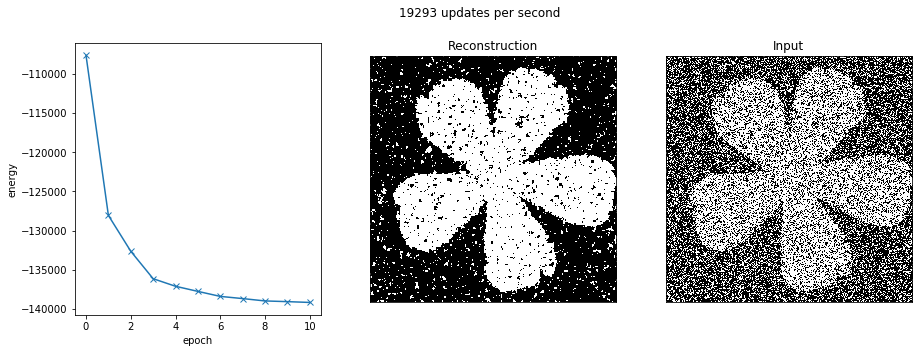

(-139178.75, 0.0736)

In [23]:
E_local = evaluate_ising(local_metropolis, *flower(size=(32,32), p=0.1), epochs=3, surpress=True);
evaluate_ising(local_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Make sure, metropolis and local_metropolis are equivalent:
    </p>

In [24]:
assert E_metro == E_local

<h2 style="background-color:#f0b375;">
Section 5.5 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 5.5 </span>
</h2>

<p style="background-color:#adebad;">
    We can speed up metropolis for the Ising model even further by using vectorized operations, i.e. using operations on arrays instead of looping over pixels.<br>
    Implement checkerboard_metropolis, which alternatingly updates two independent sub-grids at once.
    Your final code must have only one for-loop, namely over epochs (not counting the loop over the two grids). Use fftconvolve to compute the neighborhood term of the energy difference.
    </p>

In [7]:
def checkerboard_energy_change(noisy_img, estimate, grid, beta, mu):
    """Compute energy change when flipping pixels in grid
    
    When using the 4-neighborhood, a 2D image can be separated in two
    independent grids, hence the name checkerboard.
    All the pixels in one grid can be updated simultaneously, because they
    are independent. Using this property, we can improve computational
    efficiency by using vectorized operations instead of loops.
    
    Args:
        noisy_img: Noisy reference image
        estimate: Current image reconstruction
        grid: Flat array or list of grid indices.
    
    Returns:
        numpy.array: Energy change for each pixel in grid,
            same size as grid.
    
    """
    N=len(grid)#Number of pixels in a grid
    grid_energy = np.zeros(2*N)
    energy_kernel = (0.25)*(beta/2.0)*np.array([[0,1,0],[1,0,1],[0,1,0]])
    #print(energy_kernel)
    list2 = [1,0]*150 + [0,1]*150#To identify indices corresponding to convs centred on a white index
    multiplier2 = np.array( list2*150 )#Set white grids to zero
    list1 = [0,1]*150 + [1,0]*150
    multiplier1 = np.array( list1*150 )#Set black grids to zero
    grid_energy_final = np.zeros((300,150))
    
    estimate_test1 = np.multiply(estimate.copy().flatten(),multiplier2)
    estimate_test1 = estimate_test1[estimate_test1 != 0]
    estimate_test2 = np.multiply(estimate.copy().flatten(),multiplier1)
    estimate_test2 = estimate_test2[estimate_test2 != 0]
    
    #print(len(np.where(grid == estimate_test1)[0]))
    
    
    
    if((grid==estimate_test1).all()):#Black grids
        #list1 = [0,1]*150 + [1,0]*150#To identify indices corresponding to convs centred on a white index
        #multiplier1 = np.array( list1*150 )#Set black grids to zero
        estimate_only_whites = np.multiply(estimate.copy().flatten(),multiplier1)#to construct 300x300 sparse matrix with only black grids nonzero
        
        #list2 = [1,0]*150 + [0,1]*150
        #multiplier2 = np.array( list2*150 )#Set white grids to zero
        estimate_only_blacks = np.multiply(estimate.copy().flatten(),multiplier2)
        
        #estimate_only_blacks = new_estimate[new_estimate != 0]
        estimate_only_whites_arr = estimate_only_whites.reshape(300,300)
        estimate_only_blacks_arr = estimate_only_blacks.reshape(300,300)
        #print(estimate_only_whites)
        #print(len(estimate_only_blacks))
        
        noisy_only_whites = np.multiply(noisy_img.copy().flatten(),multiplier1)
        #noisy_only_blacks = new_noisy[new_noisy != 0]
        noisy_only_whites_arr = noisy_only_whites.reshape(300,300)
        
        noisy_only_blacks = np.multiply(noisy_img.copy().flatten(),multiplier2)
        #noisy_only_whites = new_noisy[new_noisy != 0]
        noisy_only_blacks_arr = noisy_only_blacks.reshape(300,300)
        
        conv_res = fftconvolve(estimate_only_whites_arr, energy_kernel,mode='same')
        
        grid_matrix_flat = np.multiply(np.repeat(grid.copy(),2),multiplier2.flatten())#interpolated grid matrix
        grid_matrix = grid_matrix_flat.reshape(300,300)
        conv_res_mult_grid = np.multiply(conv_res,grid_matrix).flatten()
        #print(conv_res_mult_grid)
        #conv_res_only_blackconvs = conv_res[(conv_res <=4) & (conv_res >=-4)] 
        grid_energy = grid_energy - 2*conv_res_mult_grid
        grid_energy = grid_energy - 1*mu*np.multiply(estimate_only_blacks_arr,noisy_only_blacks_arr).flatten()
        #print('black')
        grid_energy_matrix = grid_energy.reshape(300,300)
        grid_energy_final[0::2,0::] = grid_energy_matrix[0::2,0::2]
        grid_energy_final[1::2,0::] = grid_energy_matrix[1::2,1::2]
        
    if((grid==estimate_test2).all()):#White Grids
        #list2 = [1,0]*150 + [0,1]*150
        #multiplier2 = np.array( list2*150 )#Set black grids to zero
        estimate_only_blacks = np.multiply(estimate.copy().flatten(),multiplier2)
        
        #list1 = [0,1]*150 + [1,0]*150#To identify indices corresponding to convs centred on a white index
        #multiplier1 = np.array( list1*150 )#Set black grids to zero
        estimate_only_whites = np.multiply(estimate.copy().flatten(),multiplier1)#to construct 300x300 sparse matrix with only black grids nonzero
        
        #estimate_only_whites = new_estimate[new_estimate != 0]
        estimate_only_blacks_arr = estimate_only_blacks.reshape(300,300)
        estimate_only_whites_arr = estimate_only_whites.reshape(300,300)
        
        
        noisy_only_blacks = np.multiply(noisy_img.copy().flatten(),multiplier2)
        #noisy_only_whites = new_noisy[new_noisy != 0]
        noisy_only_blacks_arr = noisy_only_blacks.reshape(300,300)
        
        noisy_only_whites = np.multiply(noisy_img.copy().flatten(),multiplier1)
        #noisy_only_blacks = new_noisy[new_noisy != 0]
        noisy_only_whites_arr = noisy_only_whites.reshape(300,300)
        
        
        conv_res = fftconvolve(estimate_only_blacks_arr, energy_kernel,mode='same')
        
        grid_matrix_flat = np.multiply(np.repeat(grid.copy(),2),multiplier1.flatten())#interpolated grid matrix
        grid_matrix = grid_matrix_flat.reshape(300,300)
        conv_res_mult_grid = np.multiply(conv_res,grid_matrix).flatten()

        grid_energy = grid_energy - 2*conv_res_mult_grid
        #print(grid_energy)
        grid_energy = grid_energy - 1*mu*np.multiply(estimate_only_whites_arr,noisy_only_whites_arr).flatten()
        #print('white')
        grid_energy_matrix = grid_energy.reshape(300,300)
        grid_energy_final[0::2,0::] = grid_energy_matrix[0::2,1::2]
        grid_energy_final[1::2,0::] = grid_energy_matrix[1::2,0::2]
        
    #print(sum(grid_energy_final.flatten()))
    #print(len(grid_energy_final.flatten()))
    return grid_energy_final.flatten()

In [8]:
def checkerboard_metropolis(img_noisy_observation, epochs=1, T=1, beta=2.5, mu=1):
    """Metropolis sampling
    
    Alternatingly update two independent grids

    Args:
        img_noisy_observation (np.ndarray): noisy image matrix
        epochs (int): number of rounds over all pixels

    Returns:
        img_estimate (np.ndarray): reconstucted image estimate
        energies (np.ndarray): energy after each epoch
    """
    np.random.seed(100) # Always set the random seed to a lucky number

    n_pixels = img_noisy_observation.size
    
    noisy_img = img_noisy_observation.copy()
    estimate = img_noisy_observation.copy()

    N = 45000
    list1 = [1,0]*150 + [0,1]*150
    list2 = [0,1]*150 + [1,0]*150
    multiplier_1 = np.array( list1.copy()*150 )#Set white grids to zero
    multiplier_2 = np.array( list2.copy()*150 )#Set black grids to zero
    #print(([1,0]*150) + ([0,1]*150))
    grid_1 = np.multiply(img_noisy_observation.copy().flatten(),multiplier_1).copy()
    grid_2 = np.multiply(img_noisy_observation.copy().flatten(),multiplier_2).copy()
    #plt.imshow(multiplier_1.reshape(300,300))
    #print(multiplier_2.reshape(300,300))
    grid_1_new = grid_1[grid_1 != 0]
    grid_2_new = grid_2[grid_2 != 0]
    #Black Grid as a flat array
    #White Grid as a flat array 
    #print((grid_1_new == img_noisy_observation.flatten()[::2]).all())
    grids = [grid_1_new.copy(),grid_2_new.copy()]
    
    energies = []
    
    for e in range(epochs):
        
        i=0
        
        if e == 0:
            energies.append(energy(noisy_img, estimate.copy()))
            
        #print((grids[0]==grids[1]).all())FALSE
        
        for grid in grids:
            #list_loop = [(i+1)%2,i%2]*150 + [i%2,(i+1)%2]*150
            #print(i)
            #multiplier = np.array( list_loop*150 )
            if(i==0):
                multiplier = multiplier_1.copy()
            if(i==1):
                multiplier = multiplier_2.copy()
            #estimate_test_4 = np.multiply(estimate.copy().flatten(),multiplier)
            #estimate_test_4 = estimate_test_4[estimate_test_4 != 0]
            #print((grid == estimate_test_4).all())#FINE FOR THE FIRST EPOCH; MAYBE GRID INDICES AND ESTIMATE DIFFER
            #plt.imshow(multiplier.reshape(300,300),'gray',vmin=0,vmax=1)
            estimate_temp_0 = estimate.copy()#c_tilde
            #if(i==1):
                #print((estimate_temp_0 == estimate_test).all())

            grid_temp = (-1.0)*grid.copy()
            #if(i==0 and e!= 0):
                #print((estimate_temp_0 == estimate_test_2).all())
            #print((grid_temp + grids[1] == 0).all())
            #Flip the pixel corresponding to idx
            #sum1 = np.sum(estimate_temp)
            #a = estimate_temp_0.copy()
            grid_matrix_flat = np.multiply(np.repeat(grid_temp,2),multiplier).flatten()#interpolated grid matrix
            #print(grid_matrix_flat.reshape(300,300))
            grid_matrix_flat[grid_matrix_flat != 0] = -1 #So when multiplied with estimate, all the correct indices are reversed
            grid_matrix_flat[grid_matrix_flat == 0] = 1 #SO the indices of other grid aren't effected during reconstruction
            grid_matrix = grid_matrix_flat.reshape(300,300)
            #if(i==0 and e!= 0):
                #print((estimate_temp_0 == estimate_test_2).all())
            estimate_temp = np.multiply(grid_matrix,estimate_temp_0)
            #estimate_test_4 = np.multiply(estimate_temp.copy().flatten(),multiplier)
            #estimate_test_4 = estimate_test_4[estimate_test_4 != 0]
            #print((grid == estimate_test_4).all())
            #if(i==0 and e!= 0):
                #print((estimate_temp == - estimate_test_2).all())
            #plt.imshow(estimate_temp,cmap='gray')
            #print(estimate_temp)
            #sum2 = np.sum(estimate_temp)
            #print((estimate_temp_0==estimate_temp).all())
            #print('Energy_change is',np.sum(checkerboard_energy_change(noisy_img,estimate_temp,grid_temp,beta,mu)))
            #print('With old energy function',energy(noisy_img,estimate_temp)-energy(noisy_img,estimate))
            estimate_temp_test = np.multiply(estimate_temp.flatten(),multiplier)
            #estimate_temp_test = estimate_temp_test[estimate_temp_test != 0]
            #print(np.where(grid_temp == estimate_temp_test))
            #print(estimate_temp)
            #print(grid_temp)
            #Sending all the copies so can't be smt wrogn with the energy code
            p_accept = np.minimum(np.ones(45000), np.exp((-1.0/T)*((checkerboard_energy_change(noisy_img.copy(),estimate_temp.copy(),grid_temp.copy(),beta,mu)-checkerboard_energy_change(noisy_img.copy(),estimate.copy(),grid.copy(),beta,mu)))))
            accept_arr = np.array((np.random.binomial(size=45000, n=1, p=p_accept)))#Accepted are 1, rejects 0
            #print(np.where(accept_arr==1))
            grid_accept_arr = accept_arr.copy()
            grid_accept_arr[grid_accept_arr == 0] = - 1 
            grids[i] = np.multiply(grid_temp.copy(),grid_accept_arr.copy()).copy()#Accepted grid pixels are multiplied with 1, others - 1 to revert back
            #print(len(grid_accept_arr))#HHERRREEEEEEEE!!!!!!!!!!
            
            accept_arr[accept_arr == 1] = -1 
            accept_arr[accept_arr == 0] = 1 
            final_grid_matrix_flat = np.multiply(np.repeat(accept_arr.copy(),2),multiplier).flatten()#interpolated grid matrix
            final_grid_matrix_flat[final_grid_matrix_flat == 0] = 1 
            final_grid_matrix = final_grid_matrix_flat.reshape(300,300)
            estimate = np.multiply(final_grid_matrix.copy(),estimate_temp_0.copy())
            #print(grid)
            estimate_test = estimate.copy()
            
            #estimate_test_3 = np.multiply(estimate.copy().flatten(),multiplier)
            #estimate_test_3 = estimate_test_3[estimate_test_3 != 0]
            #print((grid == estimate_test_3).all())#IMPORTANT!!!!SOMETING IS OFF AFTER 0TH EPOCH
            
            if(e==0 and i==1):
                estimate_plot = estimate
            i = i + 1
            
            #plt.imshow(estimate,cmap='gray')
            #print(grid)
            #assign c_t
           
        estimate_test_2 = estimate.copy()

                
        print("Finished epoch {}".format(e+1), end="\r")
        energies.append(energy(noisy_img.copy(), estimate.copy()))
    
    #plt.imshow(estimate_plot, cmap ='gray')
    
    #np.savetxt("multiplier.csv", multiplier, delimiter=",")    
    return estimate, np.asarray(energies)

<p style="background-color:#adebad;">
    Run the checkerboard_metropolis:
    </p>

Evaluate_ising_size: (300, 300)


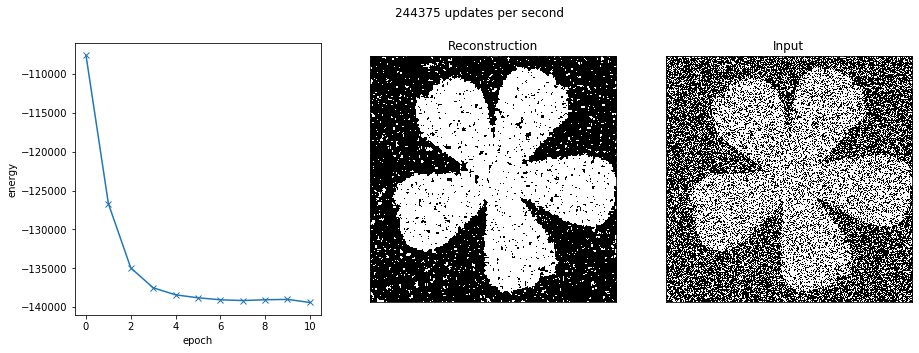

(-139389.75, 0.07038888888888889)

In [27]:
evaluate_ising(checkerboard_metropolis, *flower(), epochs=10)

<p style="background-color:#adebad;">
    Run the experiment below, and explain the observed behavior!
    </p>

Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)


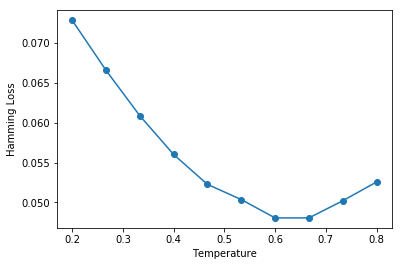

In [28]:
Trange = np.linspace(0.2,0.8,10)
loss = [evaluate_ising(checkerboard_metropolis, *flower(), epochs=10, T=T, surpress=True)[1]
         for T in np.linspace(0.2,0.8,10)]

plt.plot(Trange, loss, marker="o")
plt.ylabel("Hamming Loss")
plt.xlabel("Temperature")
plt.show()

In this experiment, the same image denoising algorithm based on checkerboard metropolis sampling is run under different tempurature parameters and the corresponding pixel-wise losses between the original image and the denoised image are plotted. From this figure, It is clear that for our given setting (noise level, image size etc.), $T\approx0.667$ seems to achieve the lowest Hamming distance to the original image and seems to be the optimal choice for our experimental setting. Moreover, intuitively, we can state that when T is very small at first trials, the sampling algorithm cannot explore the solution space sufficiently enough as to find a satisfactory estimation of the image. Likewise, at the last few trials, since T is unnecessarily large, in fact the algorithm fails to descend sufficiently into an appropiate minima due to excessive exploration of the solution space.

<p style="background-color:#adebad;">
Run the experiment below, and explain the observed behavior!
</p>

Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate_ising_size: (300, 300)
Evaluate

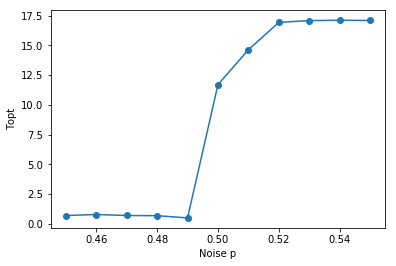

In [9]:

def find_Topt(p):
    f = lambda T: evaluate_ising(checkerboard_metropolis, *flower(p=p), epochs=10, T=T, surpress=True)[1]
    result = minimize_scalar(f, options={"xatol": 0.001}, bounds=(0, 20), method="bounded")
    return result.x

prange = np.arange(0.45, 0.55, 0.01)
with Pool(cpu_count()) as pool:
    Topt = pool.map(find_Topt, prange)
    
plt.plot(prange, Topt, marker="o")
plt.ylabel("Topt")
plt.xlabel("Noise p")
plt.show()

As pointed out in the eralier sections, the tempurature parameter is a crucial parameter that balances the effect of entropy and the cost function in the sampled Gibbs Distribution and in doing so determines the resolution of our sampled solutions. For smaller tempurature values, the cost function has a more dominant effect for the selection of new sample candidates and therefore, the algorithm is more selective when it comes to accepting new samples. Thus, the sampling procedure specifically focuses on selecting better and better solutions necessarily in terms of the cost. This is the case, as we can observe from the above curve, when the noise level is below 0.5. In this case, since the actual signal, which is the pure noiseless image in our noisy image, is more dominant with respect to the noise, we are in fact perhaps not that far from the global maxima where the sampled solutions are very close to the original image. Thus, the preferrable strategy becomes sampling solutions with necessarily less cost owing to operating at relatively lower(or medium to low) tempuratures as seen in the above curve. On the other hand, the higher the tempurature, the larger the effect of entropy on the samples, so the new candidates are accepted more easily and the solution space is explored freely. Likewise, in the above curve we observe that there is a jump in the optimal tempurature values as p becomes 0.5. This is merely due to the fact that at this critical value, noise level starts becoming stronger with respect to the noiseless image signal in our noisy observation. This means that now, we are suddenly farther away from the global minima and rather closer to the regions in the cost curve where samples are very noisy. This requires us to escape the local minima that could be faced at first iterations and roam away to farther regions in the solution space where we might actually find regions with good quality solutions as in low noise level case. Thus, the optimal tempurature values become larger in order to explore the solution space in the hope that we get farther from the noise dominated initial sample towards better solution candidates. However, of course, after some point, the increase in the noise level has no dramatic effect on the optimal tempurature since we don't have dramatic decay of initial sample qualities. The most apparent change in optimal tempurature, as stated before, occurs during the shitf to noise dominanted region at p=0.5

<h2 style="background-color:#f0b375;">
Section 6.0 
<span style=font-size:50%> Complete all problems in this and previous sections to get a grade of 6.0 </span>
</h2>

<p style="background-color:#adebad;">
Implement a more sophisticated proposal distribution, which is more appropriate for TSP than simple transpositions. <br>
Consider your idea successful, if the travel distance goes at least below 300.<br>
Moreover, make sure that your algorithm fullfills detailed balanced by using the Metropolis-Hastings acceptance probability:<br>
    $p_{accept}=\min(\frac{p(x\rightarrow y)}{p(y\rightarrow x)}e^{-\frac{\Delta E}{T}}$, 1)
</p>

In [33]:
def myfancyalgorithm(coordinates, route=None, epochs=1, T=20, eta=0.990):
    #Using Lin's 2-opt transformation as a symmetric proposal distribution choice for the metrpoplis sampling
    #Then, apply Simulated Annealing
    np.random.seed(7)
    
    N = coordinates.shape[0]
    
    
    
    if route is None:
        route = np.random.permutation(N)
    
    distances = []
    distances.append(distance(coordinates, route))

    for e in range(epochs):
        
        #counter=0
        for i in np.random.permutation(N-1):
            #counter = counter + 1
            #As a proposed sample, switch the two randomly chosen sub-paths, which is obviously symmetric since we obtain
            #our original sample when we reapply the same transformation and switch the two sub-paths back to their
            #original configurations
            k = np.random.choice(np.arange(i+1,N))
            #proposed solution sample, each route is a soln with Ndata=N:
            #print(route[idx])
            #print(route[(idx+1%532)])
            route_temp = route[:i].copy()#c_tilde
            #print(i)
            #print(len(route_temp_1))
            route_temp = np.append(route_temp.copy(),np.flip(route[i:k].copy()))
            #print(k-1)
            #print(len(route_temp_2))
            route_temp = np.append(route_temp.copy(),route[k:].copy())
            #print(len(route_temp))
            
            #print(route_temp[idx])
            #print(route_temp[(idx+1%532)])
            #For a randomized acceptance probability:
            p_accept = np.array([1, np.exp((-1.0/T)*(distance(coordinates,route_temp)-distance(coordinates,route)))]).min()
            #p_accept = ((energy(noisy_img,estimate_temp)-energy(noisy_img,estimate)) < 0)#Deterministic
            #b = np.random.binomial(size=1, n=1, p=p_accept)
            if(np.random.uniform(size=1) <= p_accept):
                route = route_temp.copy()#assign c_t
            else:
                route = route
        #print(len(route_temp))
        T = T*eta
        distances.append(distance(coordinates, route))
        #print(e)
        #print(distances[-1])
    
    return np.asarray(route), np.asarray(distances) 

<p style="background-color:#adebad;">
Evaluate your more sophisticated algorithm for the traveling salesman problem.
</p>

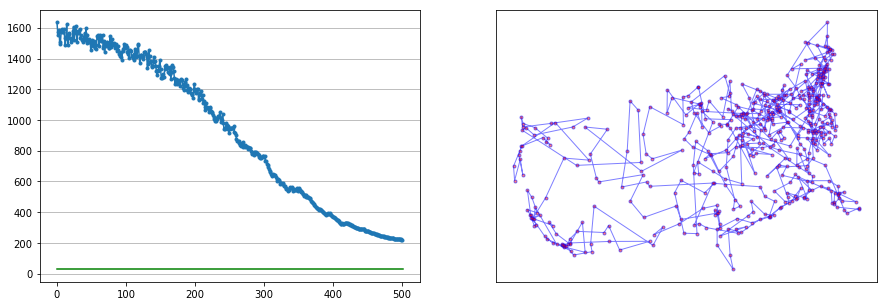

In [34]:
evaluate_tsp(myfancyalgorithm, coordinates, epochs=500)

## Comments

We hope you found this exercise instructive.

Feel free to leave comments below, we will read them carefully.

Some portion of the comments were code segments used for debugging purposes and were commented out.

Most of the commented out code segments in checkerboard metropolis and checkerboard energy were also used for debugging, hence the codes in those cells appears to be long which is due to those commented code segments.

In the beggining of Section 4.0, in order to better explain Metropolis algorithm, MCMC was described first and then the metropolis algorithm was discussed.

In some cells, the final figures are pushed down because the code also prints which epoch is running etc.
